### Libraries

In [4]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split
import unicodedata
import re
import numpy as np
import os
import io
import time
import json
import math

# Spelling Correction Library
from symspellpy import SymSpell 

# Library to create a dictionary with word and its freq in the given text
from collections import Counter

# Library to handle expand contracted words based on the context.
import contractions


### Importing Data

In [5]:
def data_import(file='train.json', max_length=200):
  with open(file, 'r') as f:
      split_data = json.load(f)
      

  query = []
  utterance = []

  for i in split_data:
      if len(i['interaction'])==0:
          q = i['final']['query']
          u = i['final']['utterance']
      else:
          q = i['interaction'][0]['query']
          u = i['interaction'][0]['utterance']
      
      if len(q)<=200:
        query.append(q)
        utterance.append(u)  
  
  return query, utterance

### Data Cleaning and Preprocessing

In [8]:
# Converts the unicode file to ascii
def unicode_to_ascii(s):
  return ''.join(c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn')

def preprocess_sentence(w):
  w = unicode_to_ascii(w.lower().strip())

  # creating a space between a word and the punctuation following it
  # eg: "he is a boy." => "he is a boy ."
  w = re.sub(r"([^A-z0-9 ])", r" \1 ", w)
  w = re.sub(r'[" "]+', " ", w)


  w = w.strip()

  # adding contractions
  w = contractions.fix(w)

  # adding a start and an end token to the sentence
  # so that the model know when to start and stop predicting.
  w = '<start> ' + w + ' <end>'
  return w


def create_dataset(path, num_examples, show_example=False):
  lines = path
  word_pairs = []
  for l in lines:
    word =preprocess_sentence(l)
    word_pairs.append(word)
  #word_pairs = preprocess_sentence(lines)
  
  if show_example:
    print(word_pairs[0])
  return  word_pairs

#### Spell checker

In [9]:
def creating_vocab(data_list):
  corpus = []
  for data in data_list:
    for sentence in data:
      tokens = sentence.split()
      corpus.extend(tokens)
  
  corpus = Counter(corpus)
  with open('dictionary.txt', 'w') as f:
    for k, v in corpus.items():
      f.write(f"{k} {v}\n")
    
def spell_checker(inputTerm, path = './dictionary.txt'):
  symspell = SymSpell()
  symspell.load_dictionary(path, term_index=0, count_index=1)
  maxEditDistance = 2
  # ignore_non_words = True means if a particular word is not present then
  # we'll return as is.
  correct_sent = []
  for i in inputTerm.split():
    if i.isalnum():
      suggestion = symspell.lookup_compound(i, maxEditDistance, ignore_non_words=True)
      suggestion = str(suggestion[0]).split(',')[0].strip()
    else:
      suggestion = i.strip()  
    correct_sent.append(suggestion)
  
  return " ".join(correct_sent)

### Tokenization and Word Embeddings

In [10]:
def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='',oov_token="<unk>")
  lang_tokenizer.fit_on_texts(lang)
  
  tensor = lang_tokenizer.texts_to_sequences(lang)

  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')

  return tensor, lang_tokenizer


In [11]:
def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, lang.index_word[t]))

### Encoder-Decoder NMT Model with Attention 

In [12]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz, emb_type='default', emb_mat=[]):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    if emb_type == 'glove':
      self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim, weights=[emb_mat])
    else:
      self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
      
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [13]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # query hidden state shape == (batch_size, hidden size)
    # query_with_time_axis shape == (batch_size, 1, hidden size)
    # values shape == (batch_size, max_len, hidden size)
    # we are doing this to broadcast addition along the time axis to calculate the score
    query_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(query_with_time_axis) + self.W2(values)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [14]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz, emb_type='default', emb_mat=[]):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units

    if emb_type == 'glove':
      self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim, weights=[emb_mat])
    else:
      self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
      
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size) 
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

### Main Function 

In [15]:
# Setting OS Path to data folder
os.chdir('../data/')

# Data Import
query, utterance = data_import('train.json')

# Variables
embedding_dim = 50
# glove_file_name = 'glove.6B.50d.txt'
# We can use either glove.6B.50d.txt or glove.840B.300d.txt

# Calling data cleaning and processing function
print('---Data after preprocessing and cleaning---')
en = create_dataset(utterance, None, show_example=True)
sql = create_dataset(query, None, show_example=True)

# Creating a spell checker based on given data to correct the input at 
# inference time
creating_vocab([en, sql])
example_sent = 'what is the number ofeemployees in each department ?'
print(f'\nSpell Checker:\nBefore: {example_sent}')
print(f'After: {spell_checker(example_sent)} \n')

# Tokenization
targ_lang, inp_lang = sql, en
input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

# Calculate max_length of the target tensors
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]

# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Show length
print('\n---Data after Train-Test Split---')
print('Train-Input, Train-Target, Val-Input, Val-Target')
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

inp_lang = inp_lang_tokenizer
targ_lang = targ_lang_tokenizer

# Showing Mapping between words and indices
print ("\nInput Language; index to word mapping")
convert(inp_lang_tokenizer, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang_tokenizer, target_tensor_train[0])

---Data after preprocessing and cleaning---
<start> what is the number of employees in each department ? <end>
<start> select count ( departmentid ) from department group by departmentid <end>

Spell Checker:
Before: what is the number ofeemployees in each department ?
After: what is the number of employees in each department ? 


---Data after Train-Test Split---
Train-Input, Train-Target, Val-Input, Val-Target
2408 2408 603 603

Input Language; index to word mapping
2 ----> <start>
11 ----> show
107 ----> info
16 ----> for
7 ----> all
528 ----> activities
6 ----> .
3 ----> <end>

Target Language; index to word mapping
4 ----> <start>
2 ----> select
10 ----> *
3 ----> from
394 ----> activity
5 ----> <end>


In [16]:
# Defining Variables for Modelling
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 32
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
steps_per_epoch_val = len(input_tensor_val)//BATCH_SIZE
units = 1024
vocab_inp_size = len(inp_lang_tokenizer.word_index)+1
vocab_tar_size = len(targ_lang_tokenizer.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

dataset_val = tf.data.Dataset.from_tensor_slices((input_tensor_val, target_tensor_val)).shuffle(BUFFER_SIZE)
dataset_val = dataset_val.batch(BATCH_SIZE, drop_remainder=True)

example_input_batch, example_target_batch = next(iter(dataset))
print(example_input_batch.shape, example_target_batch.shape)

# Encoder
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

# Attention Layer
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

# Decoder
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))



(32, 28) (32, 51)
Encoder output shape: (batch size, sequence length, units) (32, 28, 1024)
Encoder Hidden state shape: (batch size, units) (32, 1024)
Attention result shape: (batch size, units) (32, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (32, 28, 1)
Decoder output shape: (batch_size, vocab size) (32, 1855)


### Optimizer and Loss Function

In [17]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

#### Storing checkpoints

In [18]:
checkpoint_dir = '../training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

### Model Training

In [19]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1])) 

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

def val_step(inp, targ, enc_hidden):
  loss = 0

  enc_output, enc_hidden = encoder(inp, enc_hidden)

  dec_hidden = enc_hidden

  dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

  # Teacher forcing - feeding the target as the next input
  for t in range(1, targ.shape[1]):
    # passing enc_output to the decoder
    predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

    loss += loss_function(targ[:, t], predictions)

    # using teacher forcing
    dec_input = tf.expand_dims(targ[:, t], 1) 

  batch_loss = (loss / int(targ.shape[1])) 


  return batch_loss

In [20]:
EPOCHS = 30
epoch_train_loss = []
epoch_val_loss = []

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0
  total_loss_val = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

  for (batch, (inp, targ)) in enumerate(dataset_val.take(steps_per_epoch_val)):
    batch_loss_val = val_step(inp, targ, enc_hidden)
    total_loss_val += batch_loss_val

  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Train Loss {:.4f} Val Loss {:.4f}'.
        format(
            epoch + 1,
            total_loss / steps_per_epoch,
            total_loss_val / steps_per_epoch_val))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

  epoch_train_loss.append(total_loss / steps_per_epoch)
  epoch_val_loss.append(total_loss_val / steps_per_epoch_val)

Epoch 1 Train Loss 1.0274 Val Loss 0.8506
Time taken for 1 epoch 72.64982771873474 sec

Epoch 2 Train Loss 0.7376 Val Loss 0.6714
Time taken for 1 epoch 26.39044761657715 sec

Epoch 3 Train Loss 0.6086 Val Loss 0.5913
Time taken for 1 epoch 25.142155170440674 sec

Epoch 4 Train Loss 0.5385 Val Loss 0.5508
Time taken for 1 epoch 26.589497804641724 sec

Epoch 5 Train Loss 0.4974 Val Loss 0.5253
Time taken for 1 epoch 25.681341886520386 sec

Epoch 6 Train Loss 0.4653 Val Loss 0.5102
Time taken for 1 epoch 26.936709880828857 sec

Epoch 7 Train Loss 0.4388 Val Loss 0.4925
Time taken for 1 epoch 25.958912134170532 sec

Epoch 8 Train Loss 0.4135 Val Loss 0.4898
Time taken for 1 epoch 27.16251516342163 sec

Epoch 9 Train Loss 0.3938 Val Loss 0.4689
Time taken for 1 epoch 26.30979633331299 sec

Epoch 10 Train Loss 0.3742 Val Loss 0.4612
Time taken for 1 epoch 26.844789743423462 sec

Epoch 11 Train Loss 0.3536 Val Loss 0.4635
Time taken for 1 epoch 25.88298797607422 sec

Epoch 12 Train Loss 0.33

### Loading Checkpoints

In [25]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))


In [21]:
def evaluate(sentence, preprocess=False):
  attention_plot = np.zeros((max_length_targ, max_length_inp))

  if preprocess:
    sentence = preprocess_sentence(sentence)

  inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = []

  hidden = [tf.zeros((1, units))]
  enc_out, enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

  for t in range(max_length_targ):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

    predicted_id = tf.argmax(predictions[0]).numpy()
    if targ_lang.index_word[predicted_id] == '<end>':
      return " ".join(result), sentence, attention_plot    

    # storing the attention weights to plot later on
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()

    result.append(targ_lang.index_word[predicted_id])

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return " ".join(result), sentence, attention_plot

In [22]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1) 
  ax.matshow(attention, cmap='viridis')
  for (i, j), z in np.ndenumerate(attention):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()


In [23]:
def translate(sentence, plot=True, preprocess=False):
  result, sentence, attention_plot = evaluate(sentence, preprocess)

  if plot==True:
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

  return result


In [28]:
def jaccard_similarity(candidate, reference):
    """Returns the Jaccard similarity between two token lists

    Args:
        candidate (list of int): tokenized version of the candidate translation
        reference (list of int): tokenized version of the reference translation

    Returns:
        float: overlap between the two token lists
    """
    
    # convert the lists to a set to get the unique tokens
    can_unigram_set, ref_unigram_set = set(candidate), set(reference)  
    
    # get the set of tokens common to both candidate and reference
    joint_elems = can_unigram_set.intersection(ref_unigram_set)
    
    # get the set of all tokens found in either candidate or reference
    all_elems = can_unigram_set.union(ref_unigram_set)
    
    # divide the number of joint elements by the number of all elements
    overlap = len(joint_elems) / len(all_elems)
    
    return overlap

In [29]:
# for making a frequency table easily
from collections import Counter

def rouge1_similarity(system, reference):
    """Returns the ROUGE-1 score between two token lists

    Args:
        system (list of int): tokenized version of the system translation
        reference (list of int): tokenized version of the reference translation

    Returns:
        float: overlap between the two token lists
    """        
    precision, recall, rougel_score = 0, 0, 0
    # make a frequency table of the system tokens
    sys_counter = Counter(system)
    
    # make a frequency table of the reference tokens
    ref_counter = Counter(reference)
    
    # initialize overlap to 0
    overlap = 0
    
    # run a for loop over the sys_counter object
    for token in sys_counter:
        
        # lookup the value of the token in the sys_counter dictionary
        token_count_sys = sys_counter.get(token,0)
        
        # lookup the value of the token in the ref_counter dictionary
        token_count_ref = ref_counter.get(token,0)
        
        # update the overlap by getting the smaller number between the two token counts above
        overlap += min(token_count_sys, token_count_ref)
    
    precision = overlap / sum(sys_counter.values())
    recall = overlap / sum(ref_counter.values())
    
    if precision + recall != 0:
        # compute the f1-score
        rouge1_score = 2 * ((precision * recall)/(precision + recall))
    else:
        rouge1_score = 0 

    return precision, recall, rouge1_score

In [31]:
def prediction(utterance_data, query_data):
  n = len(utterance_data)
  pred = []
  targets = []
  for i in range(n):
    actual = []
    target = []
    for j in utterance_data[i]:
      if j not in [0]:
        actual.append(inp_lang_tokenizer.index_word[j])
    
    actual = " ".join(actual)

    for j in query_data[i]:
      if j not in [0]:
        if targ_lang_tokenizer.index_word[j] not in ['<start>', '<end>']:
          target.append(targ_lang_tokenizer.index_word[j])
    
    targets.append(" ".join(target))  
    pred.append(translate(f"{actual}", plot=False))
  
  return pred, targets

def evaluation_metric(pred, target, method='jaccard'):
  # print(f"Utterance: {actual}")
  # print("Gold SQL Query: ", target)
  # print("Predicted SQL Query: ", translate(f"{actual}", plot=False) )
  scores = []
  precisions = []
  recalls = []
  n = len(pred)
  for i in range(n):
    if method == 'jaccard':
      score = jaccard_similarity(pred[i].split(), target[i].split())
    elif method == 'rougel':
      precision, recall, score = rouge1_similarity(pred[i].split(), target[i].split())
      precisions.append(precision)
      recalls.append(recall)
    elif method == 'bleu':
      score = bleu_score(pred[i].split(), target[i].split())
  
    scores.append(score)
  
  if method == 'rougel':
    return np.mean(scores), np.mean(precisions), np.mean(recalls)
  else:
    return np.mean(scores)

In [32]:
pred_train, targets_train = prediction(input_tensor_train, target_tensor_train)
pred_val, targets_val = prediction(input_tensor_val, target_tensor_val)

In [33]:
jaccard_score_train = evaluation_metric(pred_train, targets_train)

In [34]:
precision_train, recall_train, rougel_score_train = evaluation_metric(pred_train, targets_train, method='rougel')

In [35]:
jaccard_score_val = evaluation_metric(pred_val, targets_val)

In [36]:
precision_val, recall_val, rougel_score_val = evaluation_metric(pred_val, targets_val, method='rougel')

In [37]:
def metric_print(precision, recall, rougel_score, jaccard_similarity, text):
  print(f'---{text}---')
  print(f'Precision: {np.round(precision, 4)}')
  print(f'Recall: {np.round(recall, 4)}')
  print(f'Rougel Similarity Score: {np.round(rougel_score, 4)}')
  print(f'Jaccard Similarity: {np.round(jaccard_similarity, 4)}')
  print('\n')

In [39]:
metric_print(precision_train, recall_train, rougel_score_train, jaccard_score_train, 'Evualtion Metrics on Training Dataset: ')
metric_print(precision_val, recall_val, rougel_score_val, jaccard_score_val, 'Evualtion Metrics on Validation Dataset: ')

---Evualtion Metrics on Training Dataset: ---
Precision: 0.9292
Recall: 0.9393
Rougel Similarity Score: 0.935
Jaccard Similarity: 0.9231


---Evualtion Metrics on Validation Dataset: ---
Precision: 0.6376
Recall: 0.6642
Rougel Similarity Score: 0.6656
Jaccard Similarity: 0.5665




#### Train and Validation Loss Plot

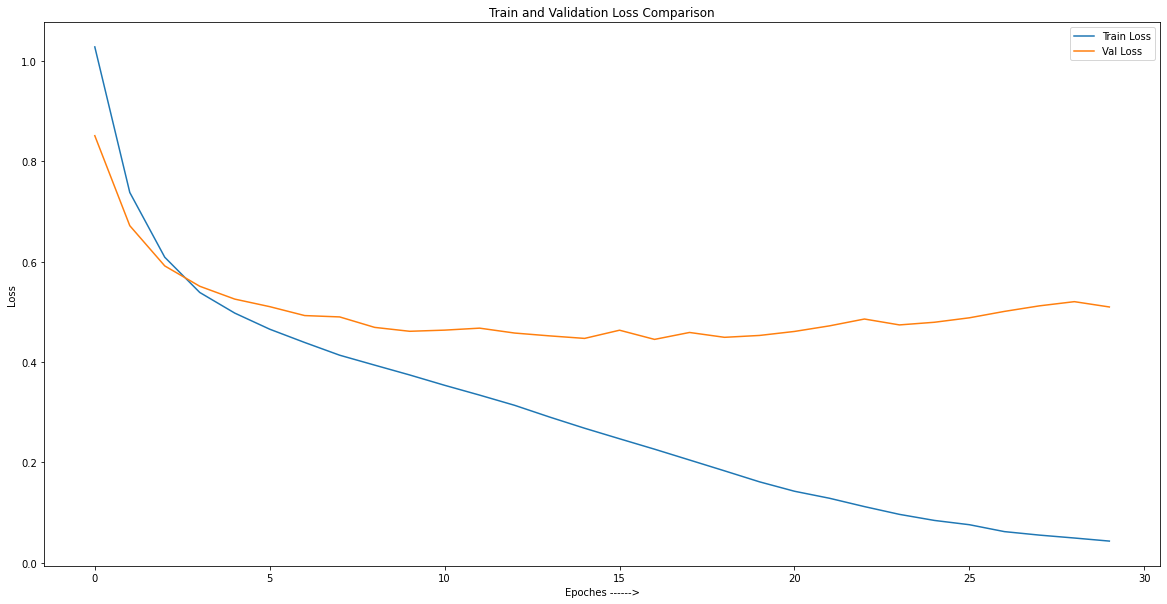

In [40]:
plt.figure(figsize=(20,10))
plt.plot(epoch_train_loss)
plt.plot(epoch_val_loss)
plt.xlabel('Epoches ------>')
plt.ylabel('Loss')
plt.legend(['Train Loss', 'Val Loss'], loc='upper right')
plt.title('Train and Validation Loss Comparison')
plt.show()


#### Real World Performance

Input: <start> how many students are there ? <end>
Predicted translation: select count ( * ) from students


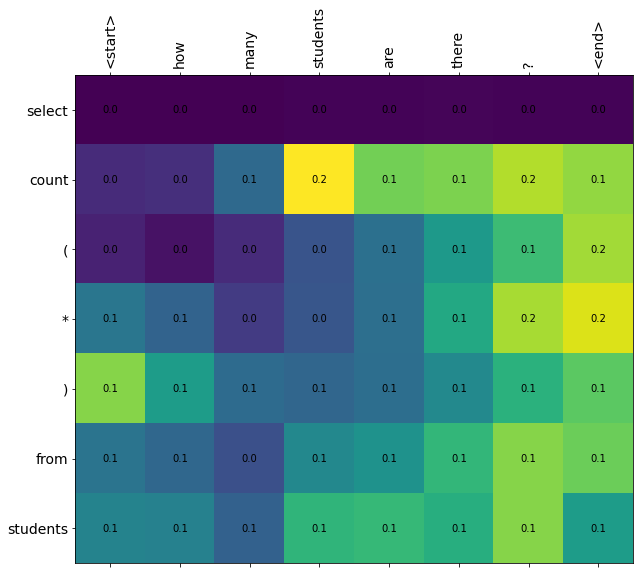

'select count ( * ) from students'

In [41]:
translate("How many students are there?", preprocess=True)

Input: <start> what is the name of a student with minimum age ? <end>
Predicted translation: select t1 . age from advisor as t1 join student as t2 on t1 . club_id = t2 . id


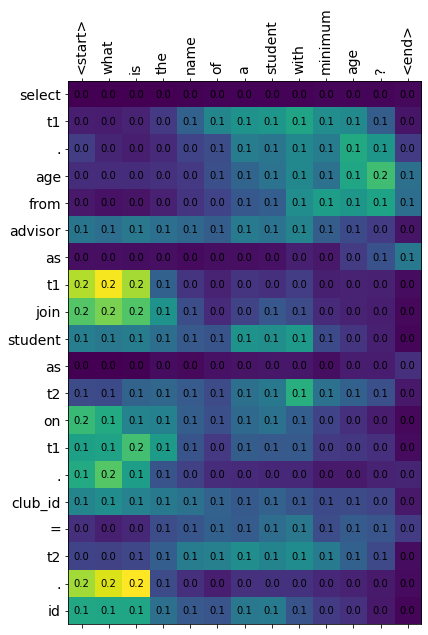

'select t1 . age from advisor as t1 join student as t2 on t1 . club_id = t2 . id'

In [42]:
translate("What is the name of a student with minimum age?", preprocess=True)

Input: <start> what is the minimum age of a student ? <end>
Predicted translation: select min ( age ) from student


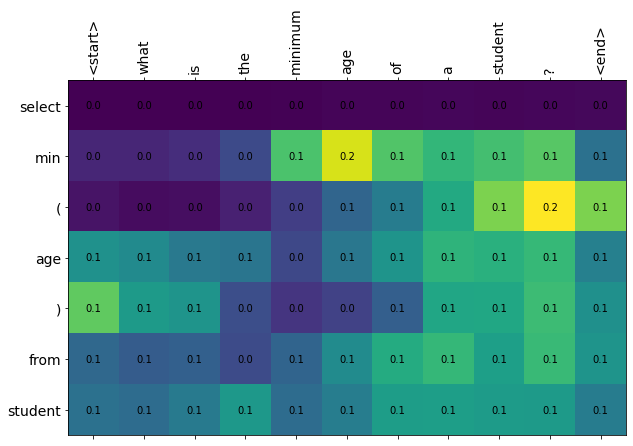

'select min ( age ) from student'

In [46]:
translate('What is the minimum age of a student?', preprocess=True)